# Kinetics II

This Notebook continues with the analysis of kinetic data obtained in a constant volume batch reactor. It considers the same data set from [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), where we applied a differential method of analysis to estimate the reaction order and rate constant for an $A \rightarrow B$ reaction. In this Notebook, we will work through the same data set using an integral method of analysis. This will result in nonlinear models that describe how species concentration varies as a function of time. When we are working with nonlinear models and data sets, we have two choices when making decisions about the model that best describes our data and in determining the numerical values of the parameters in that model. We can use nonlinear regression (nonlinear least squares) or, as in [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), we can attempt to linearize models and data and then apply the methods of linear least sqaures. We will consider both approaches here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

```{note}
This problem statement is the same as [Example Problem 01 in Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html#example-problem-01), but we will apply a new method of analysis.
```
The following reaction is carried out in a well-mixed, isothermal, constant volume batch reactor. The concentration of species $A$ and $B$ in the tank are initially $C_{A0} = 10 \mathrm{M}$ and $C_{B0} = 0 \mathrm{M}$ at $t = 0$. You may assume that the fluid inside of the reactor has constant density. 
			
$$A \longrightarrow B$$
			
We measure the concentration of species $A$ in this reactor, monitoring how it changes with time. The collected data are tabulated below. 

| time (s) | $C_A \ (\mathrm{mol \ L^{-1}})$ |  time (s)  | $C_A \ (\mathrm{mol \ L^{-1}})$ |
|:--------:|:-------------------------------:|:----------:|:-------------------------------:|
|0         | 10.0                            | 34         | 4.96                            |
|1         | 9.58                            | 55         | 4.10                            |
|2         | 9.21                            | 89         | 3.33                            |
|3         | 8.87                            | 144        | 2.68                            |
|5         | 8.30                            | 233        | 2.13                            | 
|8         | 7.62                            | 377        | 1.69                            |
|13        | 6.79                            | 610        | 1.34                            |
|21        | 5.88                            | 987        | 1.06                            |

You may assume that the rate law for this reaction follows basic, power law kinetics, i.e.:
 
$$r = k{C_A}^{\alpha}$$

where $\alpha$ is a presently unknown integer. Use the data in the above table to determine the reaction order, $\alpha$, and to estimate the rate constant, $k$, as precisely as possible.

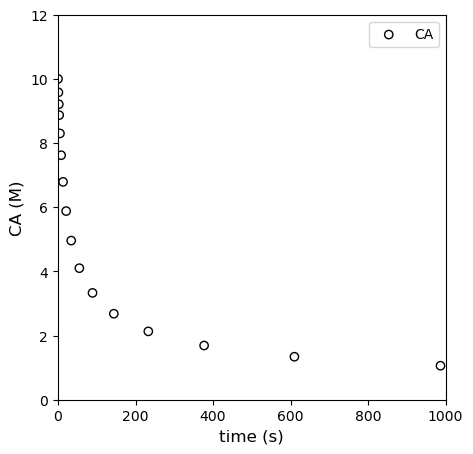

In [2]:
###################################################################################################
# Store experimental time and concentration data in separate arrays                               #
###################################################################################################

tdata  = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]) #experimental measurement time in seconds
CAdata = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])# Concentrations in moles per liter
tfine  = np.linspace(0, max(tdata), 100) #set of times on a finely spaced grid; use for generating smooth line graphs

###################################################################################################
# Graph experimental CA vs t data                                                                 #
###################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

### Solution to Example Problem 01

We want to use the data to determine the rate law and kinetic parameters $(\alpha, k)$. This is an inverse problem, and we need to find a way to extract this information from the data. Since this reaction is overall (not an elementary step), we can at most propose that the rate of reaction depends on temperature (which we capture with a rate constant) and the concentration of the reactant, $A$. At the moment, the reaction order is unknown, and propose general power law kinetics with an unknown reaction order $\alpha$.

$$r = k{C_A}^\alpha$$

As discussed in [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), the data available is a set of values for $C_A$ measured at various values of $t$. We do not yet have a model that could describe the functional relationship between $C_A$ and $t$, we only have a proposed rate law that describes the general relationship between $r$ and $C_A$. In order to model the dependence of $C_A$ on $t$, we need to solve a material balance on this batch reactor -- it may not be immediately intuitive, but we make this choice because, fundamentally, the material balance is what specifies the relationship between $C_A$ and $t$, it just does so in the form of a differential equation. We start by writing a material balance on species $A$ in this constant volume batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

For a constant volume reactor, we can divide through by $V$ and move it inside of the derivative:

$$\frac{dC_A}{dt} = R_A$$

For a single reaction, we know that $R_A = -r$, so:

$$\frac{dC_A}{dt} = -r$$

Finally, we have proposed power law kinetics, hence:

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

At this point, we make a decision about whether we want to use a ***differential*** method of analysis, where we attempt to approximate reaction rates by taking numerical derivatives of data, or an ***integral*** method of analysis, where we attempt to solve the material balance by integration and then regress parameters in the resultant model that best describe our data.  

In [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), we used a differential method of analysis. Some points about differential analysis should be clear after working through Notebook 39.

**Advantages of Differential Analysis***

1. Quick to apply using finite differences
2. Convenient when you do not know the reaction order as it will be determined by regression
3. Avoids having to guess reaction orders and solve the material balance as with integral methods

**Challenges with Differential Analysis**

1. Numerical differentiation is imprecise, and especially so when considering large changes in concentration/time
2. Imprecision arises from the assumption that the derivative is constant over the range considered, a built in feature of finite differences
3. If we aren't careful, a differential analysis can give us a false impression of true reaction kinetics, even for "perfect data" generated by a batch reactor simulation.

Today, we'll consider the integral method of analysis and highlight its strengths and weaknesses.  We'll also take this opportunity to introduce nonlinear regression, which is a very useful skill.

### Integral Analysis

As the name suggests, integral analysis of batch reactor data is based on integration, which entails solving the differential equation that comprises the batch reactor material balance.  Above, we developed the following ODE that describes the change in the concentration of species a with respect to time -- remember that at this point this is done symbolically for an arbitrary rate constant, $k$, and an arbitrary reaction order $\alpha$. As of now, we do not know either of their values, so we leave them symbolic in the material balance.

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

Now, we proceed with solving the material balance. The easiest way to do this is to guess a numerical value for the reaction order, which permits a straightforward analysical solution. Once we have an analytical solution for an assumed reaction order, we can check to see if the data are well described by that solution. If so, then we would conclude that the proposed reaction order is probably adequate. If not, we would conclude that the proposed reaction order does not describe the data, and we would repeat the procedure with a different numerical value of reaction order. Although iterating through reaction orders is somewhat tedious, it gives us a lot of information, and it has an added bonus of providing us the opportunity to compare goodness of fit across multiple models. Often, it is difficult to determine in isolation if a single model fits data well -- one can improve confidence by comparing optimal fits for many models, which is helpful in identifing the model that best describes the data.

Let's start simple by assuming (1) that the reaction order is positive and (2) that the reaction has an integer order in $A$. With this in mind, a good starting point would be to say that the reaction order is either order is either 1, 2, or 3. Once we do that, we can solve the material balance on $A$ for each reaction order to get three different analytical solutions for $C_A(t)$. We can then compare each to our data.

#### First Order Solution

For a first order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -kC_A$$

This is a separable ODE, so we'll solve it by hand.

```{note}
It is far better in kinetic analysis if you can obtain an analytical solution than having to resort to a numerical one.
```

$$\int_{C_{A0}}^{C_A}\frac{1}{C_A}dC_A = \int_0^t-kdt$$

Which gives:

$$C_A = C_{A0}\exp\left(-kt\right)$$

#### Second Order Solution

For a second order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^2$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^2}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$$

#### Third Order Solution

For a third order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^3$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^3}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$$

#### How well do these models describe the observed trends?

Now, we are ready to decide which of these models (if any!) describes our data the best. To summarize, we have 3 models to vet against our data:

**First Order**: $C_A = C_{A0}\exp\left(-kt\right)$

**Second Order**: $C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$

**Third Order**: $C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$

```{note}
The only thing we do not know in the above three models is the numerical value of the rate constant -- convince yourself that *if* we did know the rate constant, then we could generate a graph of $C_A$ vs. $t$ and visually assess whether it fits the observed data.
```

We will start with a straightforward approach. We are going to very simply guess a numerical value for the rate constant in each model. Once we do that, we can generate a graph and overlay it with the data. If the model does not fit the data, it indicates that (1) our model is incorrect, (2) we have picked an incorrect value for the rate constant, or (3) both. After assessing an initial overlay, we'll vary the value of the unknown parameter $(k)$ until we get the best possible fit to the data using a given model. As we do this, we will also quantify the total "error" in a given data fit. We'll do this by calculating the residual sum of squares, which we introduced in [Notebook 38](https://jqbond.github.io/CEN587/Notebooks/587-N38.html):

$$SSE = \sum_i (y_i - \hat{y}_i)^2$$

Here, $\bar{y}_i$ is the $i^\text{th}$ measurement of the observable $y$ at the corresponding value of independent variable, $x_i$, and $\hat{y}$ is the model prediction of the observable value ($y$) at the same condition of independent variable, $x_i$. The quantity in parentheses represents the displacement (or "error") between our model's prediction and our measurement's value.  We square it to ensure that the error is positive -- otherwise, positive and negative errors will average out to zero, making it difficult to identify the true minimum error.

In this case, we'd base our SSE on measured and model predicted values of the concentration of A since that is our observable.

$$SSE = \sum_i \left(\bar{C}_{A_i} - \hat{C}_{A_i}\right)^2$$

First, let's define each model using lambda functions; this is done in the code cell below. We do not know the value of the rate constant yet, so we are constructing these functions to take two arguments -- the rate constant and time.  Each time we want to use this function, we need to pass values of $(k,t)$. If we do so, it will calculate the resultant concentration for that particular combination of $(k,t)$.

```{note}
This is a crude approach to optimization, but it is educational, and it builds an awareness of what is involved in parameter estimation.
```

In [3]:
#############################################################################################
# The initial concentrations are well-defined and can be set as global constants            #
#############################################################################################

CA0   = 10 #mol/L

#############################################################################################
# Define CA vs t model for first order kinetics                                             #
#############################################################################################
CAONE = lambda k1, t: CA0*np.exp(-k1*t)

#############################################################################################
# Define CA vs t model for second order kinetics                                            #
#############################################################################################

CATWO = lambda k2, t: 1/(1/CA0 + k2*t)

#############################################################################################
# Define CA vs t model for third order kinetics                                             #
#############################################################################################

CATHREE = lambda k3, t: np.sqrt(1/(1/CA0**2 + 2*k3*t))

Now we can test the first order model.

With k = 1, the residual sum of squares for the first order model is SSE = 443.11


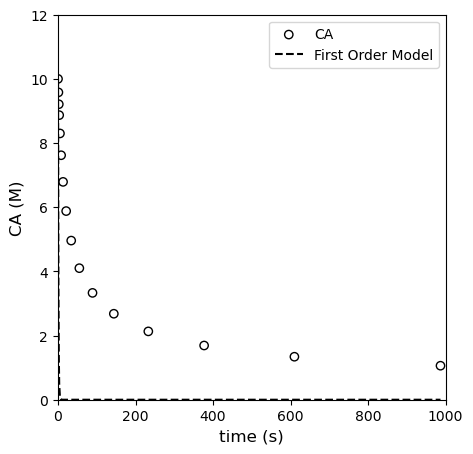

In [4]:
#############################################################################################
# Define a test value for the first order rate constant                                     #
#############################################################################################

k1test = 1  #1/s

#############################################################################################
# Pass test rate constant to a 1st order model; broadcast to tdata; generates y predictions #
#############################################################################################  

CMODONE = CAONE(k1test, tdata)

#############################################################################################
# Calculate SSE                                                                             #
#############################################################################################

SSEONE  = np.sum((CAdata - CMODONE)**2)

#############################################################################################
# Print SSE and overlay CA(t) with CA vs. t data                                            #
#############################################################################################

print(f'With k = {k1test}, the residual sum of squares for the first order model is SSE = {SSEONE:5.2f}')
plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODONE, color = 'black', linestyle = 'dashed', label = 'First Order Model')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

With k = 1, the residual sum of squares for the second order model is SSE = 494.90


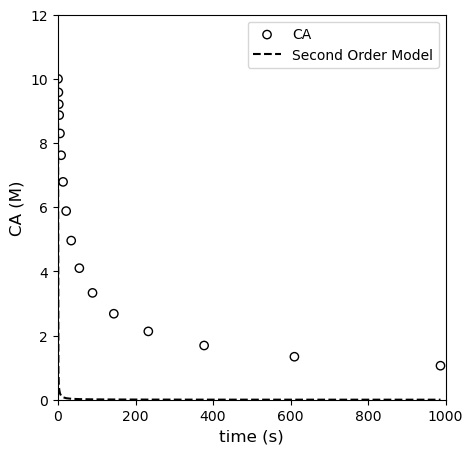

In [5]:
#############################################################################################
# Define a test value for the second order rate constant                                    #
#############################################################################################

k2test = 1  #L/mol/s

#############################################################################################
# Pass test rate constant to a 2nd order model; broadcast to tdata; generates y predictions #
#############################################################################################  

CMODTWO = CATWO(k2test, tdata)

#############################################################################################
# Calculate SSE                                                                             #
#############################################################################################

SSETWO  = np.sum((CAdata - CMODTWO)**2)

#############################################################################################
# Print SSE and overlay CA(t) with CA vs. t data                                            #
#############################################################################################

print(f'With k = {k2test}, the residual sum of squares for the second order model is SSE = {SSETWO:5.2f}')
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODTWO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

With k = 1, the residual sum of squares for the third order model is SSE = 487.35


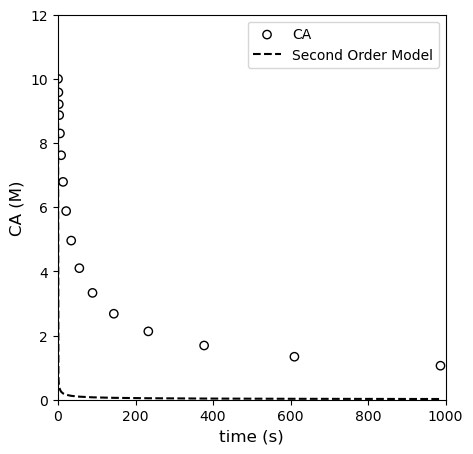

In [6]:
#############################################################################################
# Define a test value for the third order rate constant                                     #
#############################################################################################

k3test   = 1  #L^2/mol^2/s

#############################################################################################
# Pass test rate constant to a 3rd order model; broadcast to tdata; generates y predictions #
#############################################################################################  

CMODTHREE = CATHREE(k3test, tdata)

#############################################################################################
# Calculate SSE                                                                             #
#############################################################################################

SSETHREE  = np.sum((CAdata - CMODTHREE)**2)

#############################################################################################
# Print SSE and overlay CA(t) with CA vs. t data                                            #
#############################################################################################

print(f'With k = {k3test}, the residual sum of squares for the third order model is SSE = {SSETHREE:5.2f}')
plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODTHREE, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#### Nonlinear Least Squares, formally

Above, we performed a crude but intuitive optimization. We iteratively changed the value of the rate constant (a parameter) in each model until we found the value that ***minimized residual sum of squares*** and therefore best described the data. This approach is nice because it gives both visual and quantitative feedback after each iteration; unfortunately, this approach is inefficient for solving complex parameter estimation problems. In practice, we will use a more mathematically rigorous approach for parameter estimation. The basic idea is the same as we discussed in linear regression analysis ([Notebook 37](https://jqbond.github.io/CEN587/Notebooks/587-N37.html)). We will find the value of the parameter (here, the rate constant) that produces the "line of best fit." In a least squares approach, the line of best fit is defined as the one given by the value of the parameter that ***minimizes*** the residual sum of squares. We discussed linear least squares in [Notebook 37](https://jqbond.github.io/CEN587/Notebooks/587-N37.html). In that approach, we leveraged the fact that our models were linear in parameters (coefficients), which allowed us to transform large systems of linear equations into a matrix representation that we could then use to minimize the residual sum of squares. In the current analysis, we have three models that are nonlinear in parameters/time:

**First Order**: $C_A = C_{A0}\exp\left(-kt\right)$

**Second Order**: $C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$

**Third Order**: $C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$

To perform least squares analysis, we can either (1) transform these nonlinear models into linear models that we can process using linear algebra or (2) retain models in a nonlinear form, write a nonlinear objetive function that accepts $k$ as an argument and calculates residual sum of squares for a given value of $k$, and use numerical tools to minimize the objective function.  

We will use the 2nd approach first -- this approach is generally called ***nonlinear least squares*** or ***nonlinear regression***.

First, we need to define an objective function -- this is the function that we would like to minimize. Clearly, we should try to minimize the residual sum of squares! We will minimize the residual sum of squares just as we did above -- by iteratively changing the value of the parameter (rate constant) until we find a minimum residual error.  This insight motivates us to write an objective function that:

1. Takes the parameter value as an argument.
2. Calculates residual sum of squares as a function of that parameter value.  

In the cell below, we construct an objective function that accomplishes these things for the case of first order kinetics, $r = kC_A$, in a constant volume batch reactor.  As you review the code in this cell, make sure you can clearly see that the function takes the rate constant as an argument, and it calculates (and returns!) the residual sum of squares as an output.  The function additionally generates a plot that will display when you run the function -- this is helpful for illustrating how good the fit is for a given value of rate constant, but we will typically not include visualization during numerical optimization.

In [7]:
#############################################################################################
# Define objective function for first order kinetics                                        #
# Function has the form f(k) and it returns SSE                                             #
#############################################################################################

def OBJONE(k1):
    CAmodel = CAONE(k1, tdata)
    RESID   = CAdata - CAmodel
    SSE     = np.sum(RESID**2)
    print(f'k1 = {k1:9.2E}, SSE = {SSE:7.2E}')
        
    #########################################################################################
    # code block below prints SSE and graphs CA vs t when the function is run               #
    #########################################################################################

    # plt.figure(figsize = (5, 5))
    # plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
    # plt.plot(tdata, CAmodel, color = 'black', linestyle = 'dashed', label = 'First order model with k = ' + str(k))
    # plt.xlabel('time (min)', fontsize = 12)
    # plt.ylabel('CA (M)', fontsize = 12)
    # plt.xlim(0, 1000)
    # plt.ylim(0, 12)
    # plt.legend()
    # plt.show()
    return SSE

In [8]:
#############################################################################################
# Run the objective function for a test value of the first order rate constant k1           #
#############################################################################################
k1test = 1
# OBJONE(k1test)
print(f'For first order kinetics with k1 = {k1test}, the residual sum of squares is SSE = {OBJONE(k1test):5.2f}')

k1 =  1.00E+00, SSE = 4.43E+02
For first order kinetics with k1 = 1, the residual sum of squares is SSE = 443.11


#### Minimizing the error with numerical tools

Now that we have an objective function that takes our unknown parameter as an argument and returns the residual sum of squares, we can use an optimization algorithm to find the value of $k$ that minimizes the residual sum of squares. We are already familiar withe the appropriate tools in Python -- for univariate problems (we have only one unknown parameter), we would use `scipy.optimize.minimize_scalar()` and for multivariate problems (we have more than one unknown parameter), we would use `scipy.optimize.minimize()`.

Here, we are trying to minimize the objective function value with respect to a single parameter, $k$, so this is a univariate problem, and we use `scipy.optimize.minimize_scalar()`:

In [9]:
#############################################################################################
# Find the value of k1 that minimizes the objective function using opt.minimize_scalar()    #
# Show result of each iteration with print/graph in objective function                      #
# Comment sections of OBJONE(k) after demonstrating iterations                              #
#############################################################################################

ans_one = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 10])

k1 =  0.00E+00, SSE = 4.82E+02
k1 =  1.00E+00, SSE = 4.43E+02
k1 =  2.62E+00, SSE = 5.18E+02
k1 =  1.62E+00, SSE = 4.90E+02
k1 =  6.18E-01, SSE = 3.80E+02
k1 =  3.82E-01, SSE = 3.08E+02
k1 =  2.36E-01, SSE = 2.36E+02
k1 =  1.46E-01, SSE = 1.69E+02
k1 =  9.02E-02, SSE = 1.12E+02
k1 =  5.57E-02, SSE = 6.70E+01
k1 =  3.44E-02, SSE = 3.68E+01
k1 =  2.13E-02, SSE = 2.17E+01
k1 =  1.32E-02, SSE = 2.19E+01
k1 =  1.74E-02, SSE = 2.00E+01
k1 =  1.73E-02, SSE = 2.00E+01
k1 =  1.67E-02, SSE = 1.99E+01
k1 =  1.53E-02, SSE = 2.02E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01


k1 =  0.00E+00, SSE = 4.82E+02
k1 =  1.00E+00, SSE = 4.43E+02
k1 =  2.62E+00, SSE = 5.18E+02
k1 =  1.62E+00, SSE = 4.90E+02
k1 =  6.18E-01, SSE = 3.80E+02
k1 =  3.82E-01, SSE = 3.08E+02
k1 =  2.36E-01, SSE = 2.36E+02
k1 =  1.46E-01, SSE = 1.69E+02
k1 =  9.02E-02, SSE = 1.12E+02
k1 =  5.57E-02, SSE = 6.70E+01
k1 =  3.44E-02, SSE = 3.68E+01
k1 =  2.13E-02, SSE = 2.17E+01
k1 =  1.32E-02, SSE = 2.19E+01
k1 =  1.74E-02, SSE = 2.00E+01
k1 =  1.73E-02, SSE = 2.00E+01
k1 =  1.67E-02, SSE = 1.99E+01
k1 =  1.53E-02, SSE = 2.02E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01
k1 =  1.68E-02, SSE = 1.99E+01

k =  1.68E-02, SSE = 1.99E+01


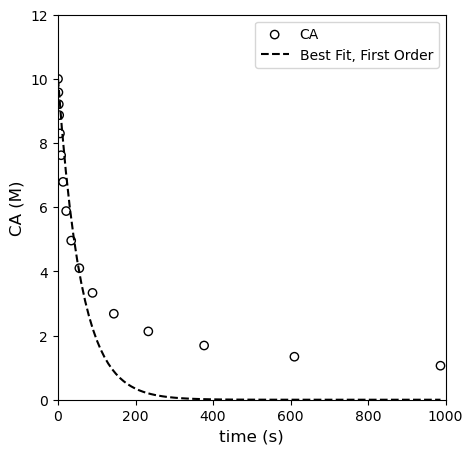

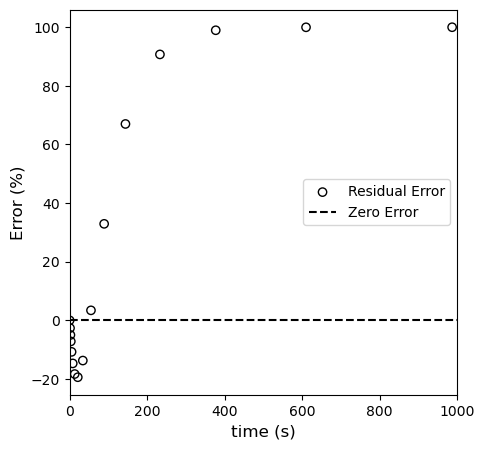

In [10]:
#############################################################################################
# Find the value of k1 that minimizes the objective function using opt.minimize_scalar()    #
#############################################################################################

ans_one = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 10])

#############################################################################################
# the .fun field in the solution structure is the minimum value of the objective function   #
#############################################################################################

SSE     = ans_one.fun

#############################################################################################
# the .x field in the solution structure is the value of k that minimizes the obj function  #
#############################################################################################

k_one   = ans_one.x

#############################################################################################
# print the optimum k1 and SSE                                                              #
#############################################################################################

print(f'\nk = {k_one:9.2E}, SSE = {SSE:7.2E}')

#############################################################################################
# Pass optimum rate constant to a 1st order model to generate CA_pred at tdata values       #
#############################################################################################

CAPREDONE = CAONE(k_one, tdata)

#############################################################################################
# Overlay best fit model with data                                                          #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tfine, CAONE(k_one, tfine), color = 'black', linestyle = 'dashed', label = 'Best Fit, First Order')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#############################################################################################
# Generate plot of residual errors -- calculate residuals as percent error                  #
# Converting the error to a percentage is not necessary                                     #
# I chose to convert to a percentage so that residuals for all models are on same y-scale   #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPREDONE)/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 1000)
plt.legend(loc = 'right')
plt.show()

#### Analysis of First Order Fit

Based on that result, the best fit value of the rate constant in a first order model is $k_1 = 0.017 \ \mathrm{s^{-1}}$, which achieves a minimum SSE of ~19.9.  Visually, it does an OK job of fitting data at low times, but it falls apart after about 100 minutes.  We notice that the first order model over-predicts measured concentration at short times, and it underpredicts at long times.  This would be a sign that the order of reaction is too low. Now we'll do the analogous optimization using a second order model and a second order rate constant. We start by defining an objective function that takes $k$ as an argument and then uses the model for $C_A(t)$ based on second order kinetics to calculate the residual sum of squares.

In [11]:
##############################################################################################
# Define an objective function that takes k2 as input and uses 2nd order model to calc SSE   #
##############################################################################################

def OBJTWO(k2):
    CAmodel = CATWO(k2, tdata)
    RESID   = CAdata - CAmodel
    SSE     = np.sum(RESID**2)
    print(f'k2 = {k2:9.2E}, SSE = {SSE:7.2E}')
    return SSE

k2 =  0.00E+00, SSE = 4.82E+02
k2 =  1.00E+00, SSE = 4.95E+02
k2 = -1.62E+00, SSE = 5.60E+02
k2 = -6.18E-01, SSE = 6.13E+02
k2 =  3.82E-01, SSE = 4.46E+02
k2 =  6.00E-01, SSE = 4.73E+02
k2 =  3.21E-01, SSE = 4.33E+02
k2 =  1.98E-01, SSE = 3.90E+02
k2 =  1.22E-01, SSE = 3.37E+02
k2 =  7.57E-02, SSE = 2.78E+02
k2 =  4.68E-02, SSE = 2.17E+02
k2 =  2.89E-02, SSE = 1.57E+02
k2 =  1.79E-02, SSE = 1.04E+02
k2 =  1.10E-02, SSE = 6.05E+01
k2 =  6.82E-03, SSE = 2.86E+01
k2 =  4.22E-03, SSE = 9.76E+00
k2 =  2.61E-03, SSE = 4.49E+00
k2 =  1.67E-03, SSE = 1.17E+01
k2 =  3.03E-03, SSE = 4.67E+00
k2 =  2.73E-03, SSE = 4.40E+00
k2 =  2.76E-03, SSE = 4.40E+00
k2 =  2.75E-03, SSE = 4.40E+00
k2 =  2.76E-03, SSE = 4.40E+00
k2 =  2.76E-03, SSE = 4.40E+00
k2 =  2.76E-03, SSE = 4.40E+00
k2 =  2.76E-03, SSE = 4.40E+00
k2 =  2.76E-03, SSE = 4.40E+00

k =  2.76E-03, SSE = 4.40E+00


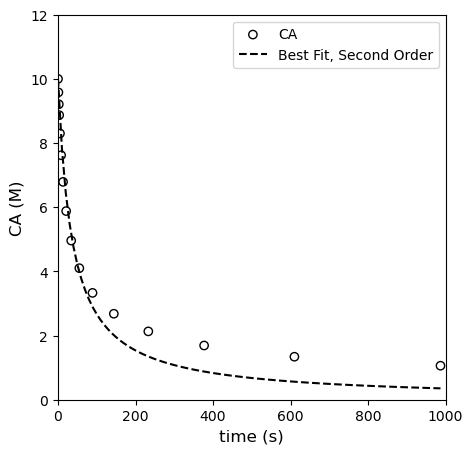

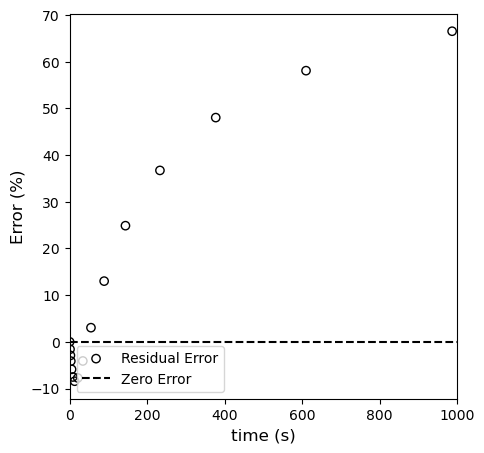

In [12]:
#############################################################################################
# Find the value of k2 that minimizes the OBJTWO using opt.minimize_scalar()                #
#############################################################################################

ans_two = opt.minimize_scalar(OBJTWO)#, method = 'Brent', bracket = [0.01, 10])

#############################################################################################
# the .fun field in the solution structure is the minimum value of the objective function   #
#############################################################################################

SSE     = ans_two.fun

#############################################################################################
# the .x field in the solution structure is the value of k that minimizes the obj function  #
#############################################################################################

k_two   = ans_two.x

#############################################################################################
# print the optimum k2 and SSE                                                              #
#############################################################################################

print(f'\nk = {k_two:9.2E}, SSE = {SSE:7.2E}')

#############################################################################################
# Pass optimum rate constant to a 2nd order model to generate CA_pred at tdata values       #
#############################################################################################

CAPREDTWO = CATWO(k_two, tdata)

#############################################################################################
# Overlay best fit model with data                                                          #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tfine, CATWO(k_two, tfine), color = 'black', linestyle = 'dashed', label = 'Best Fit, Second Order')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#############################################################################################
# Generate plot of residual errors -- calculate residuals as percent error                  #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPREDTWO)/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 1000)
plt.legend(loc = 'lower left')
plt.show()

#### Analysis of 2nd order fit

This does a better job than the first order model; we find that an optimum rate constant of $k_2 = 0.0028 \ \mathrm{L \ mol^{-1} \ min^{-1}}$ gives us a minimum sum of squares of 4.40, which is quite a bit better than the minimum sum of squares achieved with a first order model (19.9).  Still, the shape of the curve is not quite correct, and we find that the model overpredicts concentrations at short times and under predicts them at longer times.  This prompts us to test the 3rd order model. To do so, we use an analogous approach. First, we construct an objective function that takes a third order rate constant as an input argument and calculates the corresponding residual sum of squares. Once this is done, we can use `scipy.optimize.minimize_scalar()` to find the value of $k_3$ that minimizes the objective function.

In [13]:
##############################################################################################
# Define an objective function that takes k3 as input and uses 3rd order model to calc SSE   #
##############################################################################################

def OBJTHREE(k3):
    CAmodel = CATHREE(k3, tdata)
    RESID   = CAdata - CAmodel
    SSE     = np.sum(RESID**2)
    print(f'k3 = {k3:9.2E}, SSE = {SSE:7.2E}')
    return SSE

k3 =  3.82E-01, SSE = 4.61E+02
k3 =  6.18E-01, SSE = 4.75E+02
k3 =  2.36E-01, SSE = 4.42E+02
k3 =  1.46E-01, SSE = 4.19E+02
k3 =  9.02E-02, SSE = 3.92E+02
k3 =  5.57E-02, SSE = 3.59E+02
k3 =  3.45E-02, SSE = 3.21E+02
k3 =  2.13E-02, SSE = 2.77E+02
k3 =  1.32E-02, SSE = 2.30E+02
k3 =  8.14E-03, SSE = 1.81E+02
k3 =  5.03E-03, SSE = 1.33E+02
k3 =  3.12E-03, SSE = 8.89E+01
k3 =  1.93E-03, SSE = 5.19E+01
k3 =  1.20E-03, SSE = 2.39E+01
k3 =  7.43E-04, SSE = 6.34E+00
k3 =  4.63E-04, SSE = 2.00E-02
k3 =  2.90E-04, SSE = 4.89E+00
k3 =  5.02E-04, SSE = 3.02E-01
k3 =  4.60E-04, SSE = 1.10E-02
k3 =  4.49E-04, SSE = 4.06E-04
k3 =  3.88E-04, SSE = 5.58E-01
k3 =  4.52E-04, SSE = 5.86E-04
k3 =  4.46E-04, SSE = 3.03E-03

k =  4.49E-04, SSE = 4.06E-04


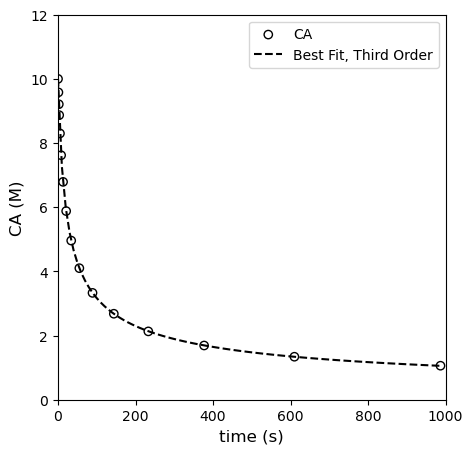

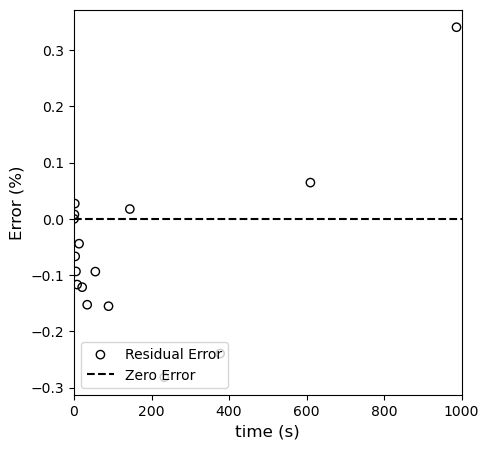

In [14]:
#############################################################################################
# Find the value of k3 that minimizes the OBJTHREE using opt.minimize_scalar()              #
# We have switched to a bounded optimization method                                         #
# This is implemented to prevent the optimizer from testing negative values of k3           #
# Physically, these aren't realistic, so we want to generally avoid negative values         #
# This is usually accomplished naturally because negative rate constants give large SSE     #
# In the case of the third order solution, the k3 value is passed to a square root          #
# This generates an imaginary number and throws an error                                    #
# Hence the need for bounds that keep the rate constant guesses positive                    #
#############################################################################################

# ans_three = opt.minimize_scalar(OBJTHREE)# Test this; it will throw a warning and not find an optiumum
ans_three = opt.minimize_scalar(OBJTHREE, method = 'Bounded', bounds = [0.00001, 1])

#############################################################################################
# the .fun field in the solution structure is the minimum value of the objective function   #
#############################################################################################

SSE       = ans_three.fun

#############################################################################################
# the .x field in the solution structure is the value of k that minimizes the obj function  #
#############################################################################################

k_three   = ans_three.x

#############################################################################################
# print the optimum k3 and SSE                                                              #
#############################################################################################

print(f'\nk = {k_three:9.2E}, SSE = {SSE:7.2E}')

#############################################################################################
# Pass optimum rate constant to a 2nd order model to generate CA_pred at tdata values       #
#############################################################################################

CAPREDTHREE = CATHREE(k_three, tdata)

#############################################################################################
# Overlay best fit model with data                                                          #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tfine, CATHREE(k_three, tfine), color = 'black', linestyle = 'dashed', label = 'Best Fit, Third Order')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#############################################################################################
# Generate plot of residual errors -- calculate residuals as percent error                  #
#############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPREDTHREE)/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 1000)
plt.legend(loc = 'lower left')
plt.show()

Now we have a great fit to the data.  This is indicated visually in the line of best fit and the residual plots, where we observe scatter around the liner of zero error. We also see this quantitatively in the minimum SSE of 4.06E-04, which is orders of magnitude smaller than the minimum SSE for first and second order models. Based on this, we would conclude that this reaction is third order in the concentration of A, and we would report that $k \approx 4.5 \times 10^{-04} \ \mathrm{L^2 \ mol^{-2} \ s^{-1}}$.


Thus far, we've used "nonlinear" regression because the models that we fit for first, second, and third order kinetics were non-linear functions of parameter values and time.  This is a powerful technique but it can also lead to problems. Most notably, when have data that is nonlinear, it is supposed to be curved in some way.  It can be hard to tell if the amount of curvature is correct.  In this case, it is easy to see, but recall that this is actually a ***perfect data set*** that was generated by solving the batch reactor material balance using third order kinetics. When we have messy, "real" data, it can be difficult to tell if the type of curvature observed in your model is correct, and it can be hard to resolve whether one nonlinear model is better than the other. Additionally, when we perform nonlinear regression, we are relying on iterative, numerical methods to perform the optimization. These can be unstable for certain objective function/parameter value combinations.

Where it is possible to do so, it is always useful to linearize a model.  This gains us a couple of important things.

1. Whereas deviation between experimental data and a curved line can be difficult to assess, it is relatively easy to detect deviations from linearity.  This makes linearization a powerful visual tool for assessing goodness of fit.
2. If we can linearize a model, we can use linear regression tools.  Regardless of how they are packaged (e.g., trendline in Excel or polyfit in Python), they are all based on similar methods that use linear algebra.  
3. The ability to leverage linear algebra means that linear least sqaures solutions solutions are deterministic. We do not need to perform iterations to identify the optimum parameter set for linear least squares problems. 
4. With nonlinear regression (as above), we are forced to use iterative optimization routines like `opt.minimize()` or `opt.minimize_scalar()`. These are not guaranteed to converge, and linear algebra solutions are typically more stable.

For these reasons, in [Notebook 41](https://jqbond.github.io/CEN587/Notebooks/587-N41.html) we will consider how to linearize these models, perform linear regression, and visually inspect the results compared to a linearized data set.